# Session 9: Multivariate Volatility Models

## Course: Advanced Volatility Modeling

---

## Learning Objectives

1. Understand the challenges of multivariate volatility modeling
2. Implement DCC (Dynamic Conditional Correlation) models
3. Explore BEKK and other multivariate GARCH specifications
4. Apply multivariate models to portfolio risk management

---

## 1. Multivariate Volatility: Motivation

### 1.1 Why Multivariate?

- **Portfolio risk**: Need covariances, not just variances
- **Contagion**: Volatility spillovers across assets
- **Hedging**: Dynamic hedge ratios
- **Time-varying correlations**: Correlations increase in crises

### 1.2 The Curse of Dimensionality

For $N$ assets, covariance matrix $H_t$ has $N(N+1)/2$ unique elements.

| N | Parameters |
|---|------------|
| 2 | 3 |
| 10 | 55 |
| 100 | 5,050 |

Need **parsimonious** specifications!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from arch import arch_model
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
# Download data for multiple assets
tickers = ['SPY', 'EFA', 'TLT', 'GLD']  # US equity, Intl equity, Bonds, Gold
data = yf.download(tickers, start='2010-01-01', end='2024-12-31', progress=False)['Close']

returns = (np.log(data / data.shift(1)) * 100).dropna()
print(f"Assets: {list(returns.columns)}")
print(f"Sample: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns)}")

YF.download() has changed argument auto_adjust default to True
Assets: ['EFA', 'GLD', 'SPY', 'TLT']
Sample: 2010-01-05 to 2024-12-30
Observations: 3772


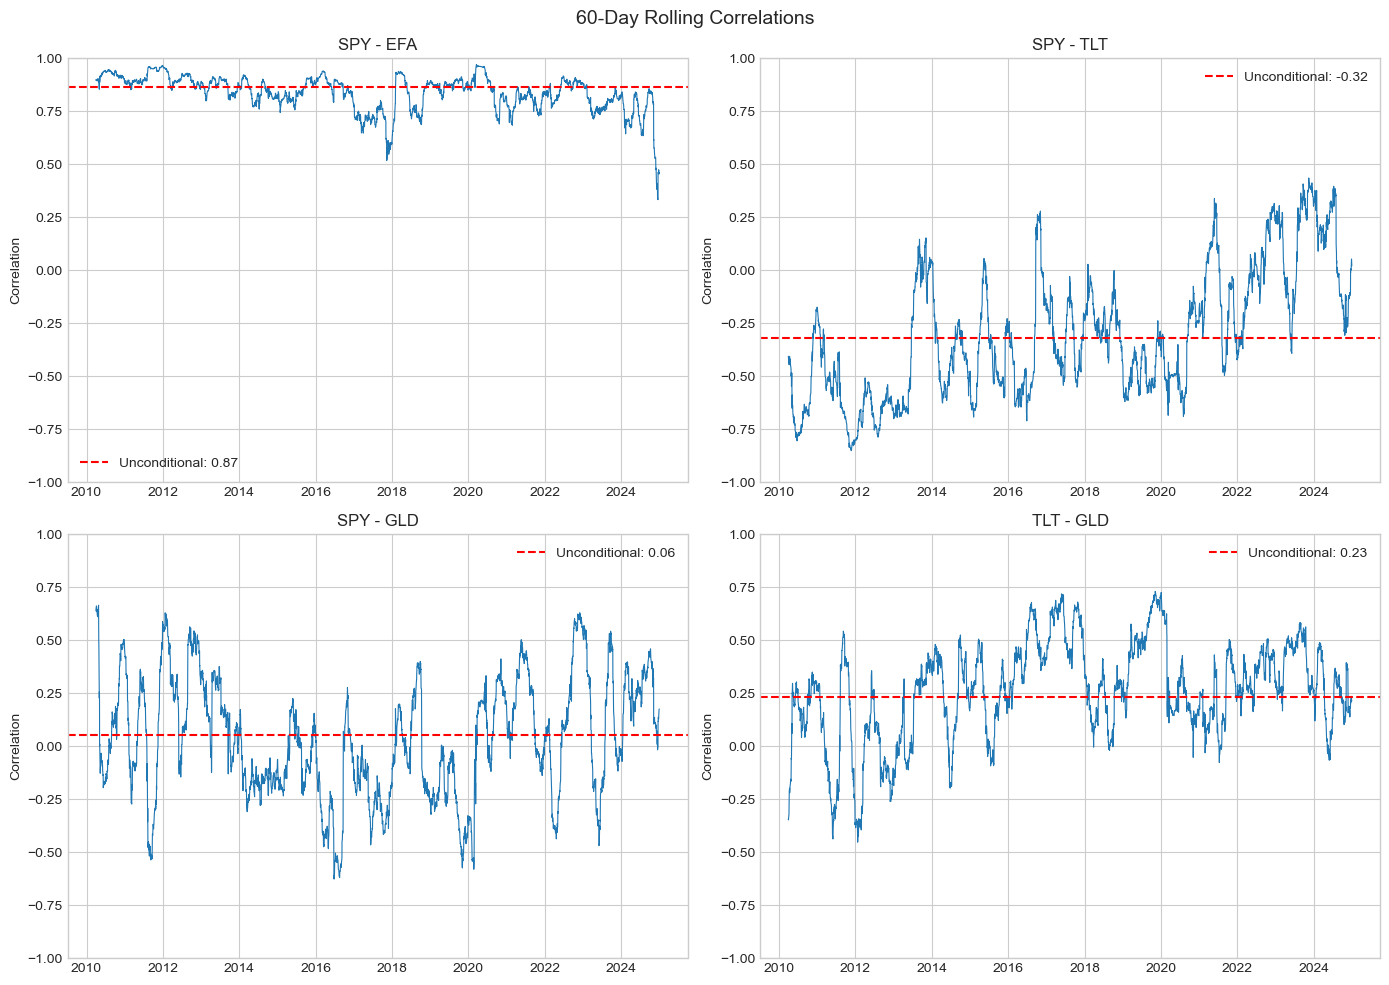

In [3]:
# Rolling correlations show time variation
window = 60

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

pairs = [('SPY', 'EFA'), ('SPY', 'TLT'), ('SPY', 'GLD'), ('TLT', 'GLD')]

for ax, (a1, a2) in zip(axes, pairs):
    rolling_corr = returns[a1].rolling(window).corr(returns[a2])
    ax.plot(rolling_corr.index, rolling_corr.values, linewidth=0.8)
    ax.axhline(returns[a1].corr(returns[a2]), color='red', linestyle='--', 
               label=f'Unconditional: {returns[a1].corr(returns[a2]):.2f}')
    ax.set_title(f'{a1} - {a2}')
    ax.set_ylabel('Correlation')
    ax.legend()
    ax.set_ylim(-1, 1)

plt.suptitle(f'{window}-Day Rolling Correlations', fontsize=14)
plt.tight_layout()
plt.show()

## 2. DCC Model (Engle, 2002)

### 2.1 Two-Step Approach

**Step 1**: Fit univariate GARCH to each series
$$r_{i,t} = \sigma_{i,t} z_{i,t}$$

**Step 2**: Model correlations of standardized residuals

### 2.2 DCC Specification

$$H_t = D_t R_t D_t$$

where:
- $D_t = \text{diag}(\sigma_{1,t}, ..., \sigma_{N,t})$: diagonal matrix of volatilities
- $R_t$: time-varying correlation matrix

$$Q_t = (1 - a - b)\bar{Q} + a(z_{t-1}z_{t-1}') + bQ_{t-1}$$
$$R_t = \text{diag}(Q_t)^{-1/2} Q_t \text{diag}(Q_t)^{-1/2}$$

In [5]:
def fit_univariate_garch(returns_df):
    """Step 1: Fit GARCH(1,1) to each series."""
    models = {}
    volatilities = pd.DataFrame(index=returns_df.index)
    std_residuals = pd.DataFrame(index=returns_df.index)
    
    for col in returns_df.columns:
        model = arch_model(returns_df[col], vol='Garch', p=1, q=1)
        fit = model.fit(disp='off')
        models[col] = fit
        volatilities[col] = fit.conditional_volatility
        std_residuals[col] = fit.std_resid
    
    return models, volatilities, std_residuals.dropna()

# Fit univariate models
garch_models, volatilities, std_resid = fit_univariate_garch(returns)

print("Univariate GARCH Parameters:")
print("="*60)
for col, model in garch_models.items():
    params = model.params
    print(f"\n{col}:")
    print(f"  ω = {params['omega']:.6f}")
    print(f"  α = {params['alpha[1]']:.4f}")
    print(f"  β = {params['beta[1]']:.4f}")
    print(f"  Persistence = {params['alpha[1]'] + params['beta[1]']:.4f}")

Univariate GARCH Parameters:

EFA:
  ω = 0.025149
  α = 0.1256
  β = 0.8598
  Persistence = 0.9854

GLD:
  ω = 0.018372
  α = 0.0540
  β = 0.9272
  Persistence = 0.9813

SPY:
  ω = 0.037661
  α = 0.1692
  β = 0.7987
  Persistence = 0.9679

TLT:
  ω = 0.016410
  α = 0.0670
  β = 0.9146
  Persistence = 0.9816


In [6]:
def dcc_loglik(params, std_resid):
    """
    DCC log-likelihood (Step 2).
    
    Parameters
    ----------
    params : array
        [a, b] DCC parameters
    std_resid : DataFrame
        Standardized residuals from Step 1
    """
    a, b = params
    
    # Constraints
    if a < 0 or b < 0 or a + b >= 1:
        return 1e10
    
    z = std_resid.values
    T, N = z.shape
    
    # Unconditional correlation
    Q_bar = np.corrcoef(z.T)
    
    # Initialize
    Q = Q_bar.copy()
    loglik = 0
    
    for t in range(T):
        # Update Q
        if t > 0:
            z_tm1 = z[t-1:t].T
            Q = (1 - a - b) * Q_bar + a * (z_tm1 @ z_tm1.T) + b * Q
        
        # Convert Q to correlation matrix R
        Q_diag_inv_sqrt = np.diag(1 / np.sqrt(np.diag(Q)))
        R = Q_diag_inv_sqrt @ Q @ Q_diag_inv_sqrt
        
        # Log-likelihood contribution
        try:
            det_R = np.linalg.det(R)
            if det_R <= 0:
                return 1e10
            R_inv = np.linalg.inv(R)
            z_t = z[t:t+1].T
            loglik += -0.5 * (np.log(det_R) + z_t.T @ R_inv @ z_t - z_t.T @ z_t)
        except:
            return 1e10
    
    return -float(loglik)

def fit_dcc(std_resid):
    """Fit DCC model (Step 2)."""
    result = minimize(
        dcc_loglik,
        [0.05, 0.90],
        args=(std_resid,),
        method='Nelder-Mead',
        options={'maxiter': 1000}
    )
    return result

# Fit DCC
dcc_result = fit_dcc(std_resid)
a_hat, b_hat = dcc_result.x

print("DCC Estimation Results")
print("="*50)
print(f"a = {a_hat:.4f}")
print(f"b = {b_hat:.4f}")
print(f"Persistence (a+b) = {a_hat + b_hat:.4f}")

DCC Estimation Results
a = 0.0338
b = 0.9486
Persistence (a+b) = 0.9823


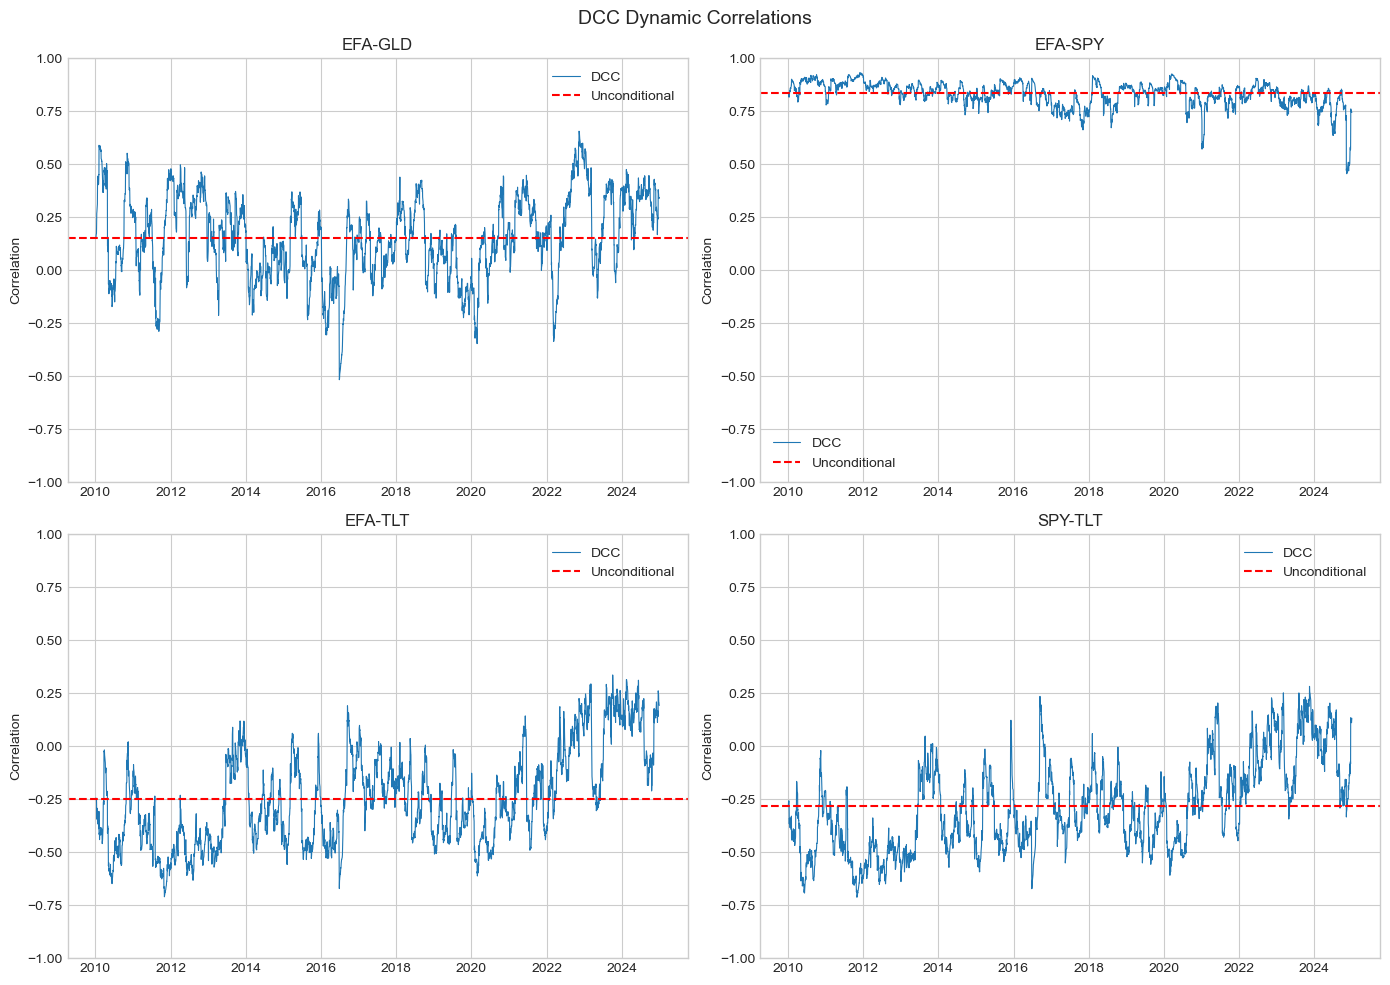

In [7]:
def compute_dcc_correlations(std_resid, a, b):
    """Compute time-varying correlations from DCC model."""
    z = std_resid.values
    T, N = z.shape
    
    Q_bar = np.corrcoef(z.T)
    Q = Q_bar.copy()
    
    correlations = np.zeros((T, N, N))
    
    for t in range(T):
        if t > 0:
            z_tm1 = z[t-1:t].T
            Q = (1 - a - b) * Q_bar + a * (z_tm1 @ z_tm1.T) + b * Q
        
        Q_diag_inv_sqrt = np.diag(1 / np.sqrt(np.diag(Q)))
        R = Q_diag_inv_sqrt @ Q @ Q_diag_inv_sqrt
        correlations[t] = R
    
    return correlations

# Compute DCC correlations
dcc_corr = compute_dcc_correlations(std_resid, a_hat, b_hat)

# Plot dynamic correlations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
cols = list(std_resid.columns)

idx_pairs = [(0, 1), (0, 2), (0, 3), (2, 3)]
labels = [f'{cols[i]}-{cols[j]}' for i, j in idx_pairs]

for ax, (i, j), label in zip(axes, idx_pairs, labels):
    dcc_series = dcc_corr[:, i, j]
    ax.plot(std_resid.index, dcc_series, linewidth=0.8, label='DCC')
    ax.axhline(np.corrcoef(std_resid.iloc[:, i], std_resid.iloc[:, j])[0,1],
               color='red', linestyle='--', label='Unconditional')
    ax.set_title(label)
    ax.set_ylabel('Correlation')
    ax.legend()
    ax.set_ylim(-1, 1)

plt.suptitle('DCC Dynamic Correlations', fontsize=14)
plt.tight_layout()
plt.show()

## 3. BEKK Model

### 3.1 Specification (Engle & Kroner, 1995)

$$H_t = C'C + A' \epsilon_{t-1}\epsilon_{t-1}' A + B' H_{t-1} B$$

where $C$ (lower triangular), $A$, $B$ are $N \times N$ matrices.

### 3.2 Scalar BEKK

For parsimony, assume $A = a I_N$ and $B = b I_N$:

$$H_t = C'C + a^2 \epsilon_{t-1}\epsilon_{t-1}' + b^2 H_{t-1}$$

In [9]:
def scalar_bekk_loglik(params, returns):
    """
    Scalar BEKK log-likelihood.
    
    H_t = C'C + a² * eps_{t-1} eps_{t-1}' + b² * H_{t-1}
    """
    r = returns.values
    T, N = r.shape
    
    # Extract parameters
    n_c = N * (N + 1) // 2  # Lower triangular elements
    c_params = params[:n_c]
    a, b = params[n_c], params[n_c + 1]
    
    # Constraints
    if a < 0 or b < 0 or a**2 + b**2 >= 1:
        return 1e10
    
    # Build C matrix
    C = np.zeros((N, N))
    idx = 0
    for i in range(N):
        for j in range(i + 1):
            C[i, j] = c_params[idx]
            idx += 1
    
    CC = C @ C.T
    
    # Sample covariance for initialization
    H = np.cov(r.T)
    
    loglik = 0
    for t in range(1, T):
        eps = r[t-1:t].T
        H = CC + a**2 * (eps @ eps.T) + b**2 * H
        
        try:
            det_H = np.linalg.det(H)
            if det_H <= 0:
                return 1e10
            H_inv = np.linalg.inv(H)
            r_t = r[t:t+1].T
            loglik += -0.5 * (N * np.log(2*np.pi) + np.log(det_H) + r_t.T @ H_inv @ r_t)
        except:
            return 1e10
    
    return -float(loglik)

# Fit Scalar BEKK (2 assets for speed)
returns_2 = returns[['SPY', 'TLT']]
N = 2
n_c = N * (N + 1) // 2

# Initial values
cov_init = np.cov(returns_2.values.T)
C_init = np.linalg.cholesky(cov_init * 0.1)
c_init = [C_init[i, j] for i in range(N) for j in range(i + 1)]

result_bekk = minimize(
    scalar_bekk_loglik,
    c_init + [0.2, 0.9],
    args=(returns_2,),
    method='Nelder-Mead',
    options={'maxiter': 2000}
)

a_bekk = result_bekk.x[n_c]
b_bekk = result_bekk.x[n_c + 1]

print("Scalar BEKK Results (SPY-TLT)")
print("="*50)
print(f"a = {a_bekk:.4f}")
print(f"b = {b_bekk:.4f}")
print(f"Persistence (a²+b²) = {a_bekk**2 + b_bekk**2:.4f}")

Scalar BEKK Results (SPY-TLT)
a = 0.3071
b = 0.9388
Persistence (a²+b²) = 0.9757


## 4. Portfolio Risk Application

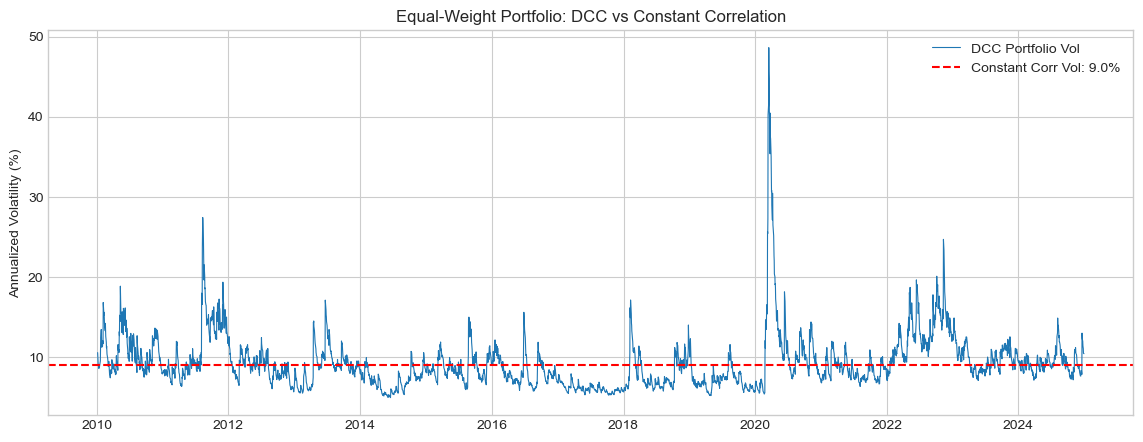


Average DCC portfolio vol: 9.24%
Max DCC portfolio vol: 48.61%
Constant correlation vol: 9.00%


In [11]:
def compute_portfolio_vol(weights, H):
    """Compute portfolio volatility from covariance matrix."""
    w = np.array(weights).reshape(-1, 1)
    return np.sqrt(w.T @ H @ w)[0, 0]

# Compute DCC covariance matrices
def compute_dcc_covariances(volatilities, dcc_corr):
    """Convert DCC correlations to covariances."""
    T = len(volatilities)
    N = volatilities.shape[1]
    H = np.zeros((T, N, N))
    
    for t in range(T):
        D = np.diag(volatilities.iloc[t].values)
        H[t] = D @ dcc_corr[t] @ D
    
    return H

# Equal-weight portfolio
weights = np.array([0.25, 0.25, 0.25, 0.25])

# Align volatilities with std_resid index
vol_aligned = volatilities.loc[std_resid.index]
H_dcc = compute_dcc_covariances(vol_aligned, dcc_corr)

# Portfolio volatility over time
port_vol = [compute_portfolio_vol(weights, H_dcc[t]) * np.sqrt(252) for t in range(len(std_resid))]

# Constant correlation benchmark
corr_const = np.corrcoef(returns.T)
vol_mean = volatilities.mean()
D_const = np.diag(vol_mean.values)
H_const = D_const @ corr_const @ D_const
port_vol_const = compute_portfolio_vol(weights, H_const) * np.sqrt(252)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(std_resid.index, port_vol, linewidth=0.8, label='DCC Portfolio Vol')
ax.axhline(port_vol_const, color='red', linestyle='--', label=f'Constant Corr Vol: {port_vol_const:.1f}%')
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('Equal-Weight Portfolio: DCC vs Constant Correlation')
ax.legend()
plt.show()

print(f"\nAverage DCC portfolio vol: {np.mean(port_vol):.2f}%")
print(f"Max DCC portfolio vol: {np.max(port_vol):.2f}%")
print(f"Constant correlation vol: {port_vol_const:.2f}%")

## 5. Summary

### Key Takeaways

1. **DCC**: Two-step approach - univariate GARCH then correlation dynamics
2. **BEKK**: Direct modeling of covariance matrix (more parameters)
3. **Time-varying correlations**: Crucial for risk management
4. **Portfolio risk**: DCC captures crisis correlation spikes

### Preview: Session 10
Path-dependent volatility and practical applications.

## Exercises

1. Implement asymmetric DCC (ADCC) with leverage effect
2. Compare DCC vs rolling correlation for hedge ratios
3. Estimate DCC for crypto-equity portfolio
4. Backtest minimum variance portfolio with DCC vs constant correlation

## References

1. Engle, R. (2002). Dynamic conditional correlation. *Journal of Business & Economic Statistics*, 20(3), 339-350.
2. Engle, R. F., & Kroner, K. F. (1995). Multivariate simultaneous generalized ARCH. *Econometric Theory*, 11(1), 122-150.
3. Bauwens, L., Laurent, S., & Rombouts, J. V. (2006). Multivariate GARCH models: a survey. *Journal of Applied Econometrics*, 21(1), 79-109.